In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv


from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score, RandomizedSearchCV


from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import classification_report, cohen_kappa_score, balanced_accuracy_score, accuracy_score, confusion_matrix
from scipy import stats



In [2]:
# Four classes of mortality classification
classes = ['dead', 'mixed', 'live', 'Other']
class_order = [0, 2, 1, 3]
class_names = ['Dead', 'Live', 'Mixed', 'Other']

In [3]:
# Reading train-test set files 

trainRGB = pd.read_csv("data/training_data/ml_data/RGB_train_final.csv")
testRGB = pd.read_csv("data/training_data/ml_data/RGB_test_final.csv")

testRGB.head()

,Min1,FirstQuard1,Median1,ThirdQuard1,Max1,Mean1,STD1,Min2,FirstQuard2,Median2,...,Min3,FirstQuard3,Median3,ThirdQuard3,Max3,Mean3,STD3,filename,Tree_class,Tree_val
0,81,172.0,187.0,199.0,255,185.987654,27.661604,79,163.0,175.0,...,73,125.0,136.0,147.0,204,135.634259,19.353142,2018_live_989_24817.tif,live,2
1,60,118.0,163.0,210.0,255,161.703312,53.354525,35,111.0,158.0,...,52,91.0,106.0,150.0,230,120.314306,38.024283,2018_live_985_24721.tif,live,2
2,71,157.0,180.0,205.0,255,181.988717,40.575649,65,137.0,156.0,...,46,108.0,120.0,141.0,193,125.557382,27.376219,2018_live_973_76777.tif,live,2
3,59,96.0,157.0,184.0,255,148.590781,51.088701,52,88.0,142.0,...,50,95.0,112.0,127.0,255,115.351651,26.449692,2018_live_972_76770.tif,live,2
4,70,154.0,183.0,220.0,255,183.077295,46.270287,62,136.0,159.0,...,61,109.0,125.0,155.5,255,131.022165,30.939479,2018_live_970_76752.tif,live,2


In [4]:
 # creating separate target col and drop it from train and test set
target_train = trainRGB['Tree_val']
train = trainRGB.drop(columns = ['Tree_class', 'Tree_val', 'filename'])

target_test = testRGB['Tree_val']
test = testRGB.drop(columns = ['Tree_class', 'Tree_val', 'filename'])

In [5]:
print(train.shape, target_train.shape) 
print(test.shape, target_test.shape) 

(12213, 21) (12213,)
(3048, 21) (3048,)


In [6]:
# standardizing all the predictor dataset 
def standardizeFun(v):
    std = v.std()
    if std == 0:
        return np.zeros (len(v))
    else:
        return (v - v.mean())/std
    
# Standardize function for the test set using the mean and SD of train set
def standardize_test(train, test):
    std = train.std()
    if std == 0:
        return np.zeros(len(test))
    else:
        return (test - train.mean()) / std

In [7]:
# train set normalization------------------------------------------------------------------------------------------------
features_names = list(train.columns)

features = {}
for feat in features_names:
    features[feat] = standardizeFun(train[feat])
    
train_features = pd.DataFrame(features)

# test set normalization --------------------------------------------------------------------------------------------------
features_names = list(test.columns)

features_test = {}
for feats in features_names:
    features_test[feats] = standardize_test(train[feats], test[feats])
    
test_features = pd.DataFrame(features_test)

In [8]:
X_train = train_features # standardize features
Y_train = target_train 

X_test = test_features # standardize features
Y_test = target_test 

In [9]:
X_train.head()

,Min1,FirstQuard1,Median1,ThirdQuard1,Max1,Mean1,STD1,Min2,FirstQuard2,Median2,...,Max2,Mean2,STD2,Min3,FirstQuard3,Median3,ThirdQuard3,Max3,Mean3,STD3
0,1.065863,0.156287,0.551273,0.797440,0.513776,0.602368,0.559822,0.808104,0.120756,0.559678,...,0.858253,0.390241,-0.164761,0.015550,0.271101,0.212715,0.362907,1.163474,0.391896,-0.015009
1,0.602368,0.657647,0.815763,0.825705,0.513776,0.883236,0.463520,0.533432,0.679073,0.857128,...,0.858253,0.849136,0.135975,0.229469,0.456596,0.490434,0.399203,1.163474,0.622900,0.528897
2,1.613631,0.475334,-0.073886,-0.672358,0.513776,0.034624,-1.472151,1.540563,0.651157,0.262228,...,0.770181,0.328659,-1.487426,0.603828,-0.007142,-0.501421,-0.907477,0.979589,-0.480453,-0.905292
3,1.276543,0.771592,0.599362,0.429991,0.513776,0.666965,-0.336461,1.494784,0.958231,0.857128,...,0.814217,0.866200,-0.552184,1.299065,0.456596,0.252389,0.108830,0.112704,0.320405,-0.467381
4,0.770912,-0.162761,-0.194109,-0.135316,0.513776,0.013842,0.174450,0.899662,-0.242150,-0.392163,...,-0.022471,-0.282344,-0.494747,1.406025,0.271101,-0.025330,-0.217840,-0.228796,0.146079,-0.446547


### Random Forest Using RandomSearchCV

In [10]:
# Set seed for reproductibility
seed = 12
np.random.seed(seed)

rf = RandomForestClassifier(oob_score=True)
np.random.seed(seed)

rf_paramgrid = {'n_estimators': [100, 200, 500],
                'criterion': ['gini', 'entropy'],
                'min_samples_split': list(range(2,5)),
                'max_features': ['auto', 'log2', None],
                'class_weight': ['balanced', None],
                 'random_state': [seed]}

rf_search = RandomizedSearchCV(rf, rf_paramgrid, cv=5, n_iter=5, n_jobs=-1, verbose=2, random_state=seed)


In [11]:
rf_search.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   23.3s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   45.5s remaining:   11.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   48.0s finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(oob_score=True),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_features': ['auto', 'log2', None],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [100, 200, 500],
                                        'random_state': [12]},
                   random_state=12, verbose=2)

In [12]:
best_rf = rf_search.best_estimator_
print(best_rf)
rf_preds_train = best_rf.predict(X_train)
rf_preds = best_rf.predict(X_test)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       min_samples_split=4, n_estimators=500, oob_score=True,
                       random_state=12)


In [13]:
print(f'OA: {accuracy_score(Y_test, rf_preds):.2f}, BA: {balanced_accuracy_score(Y_test, rf_preds):.2f}, Kappa: {cohen_kappa_score(Y_test, rf_preds):.2f}')
print(classification_report(Y_test, rf_preds, target_names=classes))

OA: 0.82, BA: 0.60, Kappa: 0.62
              precision    recall  f1-score   support

        dead       0.79      0.83      0.81       550
       mixed       0.46      0.14      0.22       349
        live       0.84      0.96      0.90      1980
       Other       0.72      0.44      0.55       169

    accuracy                           0.82      3048
   macro avg       0.70      0.60      0.62      3048
weighted avg       0.78      0.82      0.79      3048



In [14]:
print('Train accuracy', accuracy_score(Y_train, rf_preds_train)*100)
print('Validation accuracy', (rf_search.best_score_)*100)
print('Test accuracy', accuracy_score(Y_test, rf_preds)*100)

Train accuracy 99.9508720216163
Validation accuracy 81.02832039794791
Test accuracy 81.59448818897637


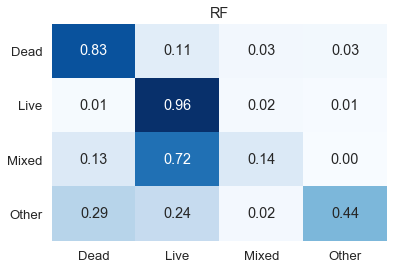

In [15]:
cm = confusion_matrix(Y_test, rf_preds)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("RF")
plt.yticks(rotation=0)
plt.show()

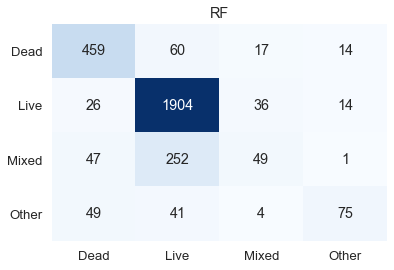

In [16]:
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(reordered_cm, annot=True, cmap="Blues", fmt="0", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("RF")
plt.yticks(rotation=0)
plt.show()

### RANDOM FOREST without RandomSearchCV

In [17]:
RSEED = 50
modelRF = RandomForestClassifier(n_estimators=50, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1, max_depth=25)

# Fit on training data
modelRF.fit(X_train,Y_train)

# prediction on both train and test data
Y_test_Preds_RF = modelRF.predict(X_test)

# accuracy
print('Test accuracy', accuracy_score(Y_test, Y_test_Preds_RF))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished


Test accuracy 0.8116797900262467


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished


In [19]:
print(f'OA: {accuracy_score(Y_test, Y_test_Preds_RF):.2f}, BA: {balanced_accuracy_score(Y_test, Y_test_Preds_RF):.2f}, Kappa: {cohen_kappa_score(Y_test, Y_test_Preds_RF):.2f}')
print(classification_report(Y_test, Y_test_Preds_RF, target_names=classes))

OA: 0.81, BA: 0.60, Kappa: 0.61
              precision    recall  f1-score   support

        dead       0.79      0.82      0.81       550
       mixed       0.41      0.15      0.22       349
        live       0.85      0.95      0.90      1980
       Other       0.69      0.47      0.56       169

    accuracy                           0.81      3048
   macro avg       0.68      0.60      0.62      3048
weighted avg       0.78      0.81      0.78      3048



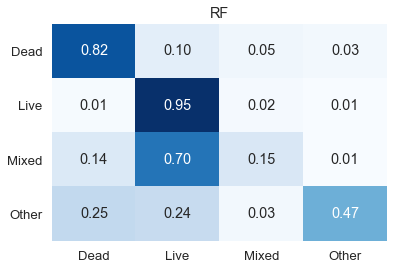

In [20]:
cm = confusion_matrix(Y_test, Y_test_Preds_RF)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("RF")
plt.yticks(rotation=0)

plt.show()

## Support Vector Machine with RandomizedSearchCV

In [21]:
# SVM with linear kernel
np.random.seed(seed)

lin_svm = SVC()

lin_svm_paramgrid = {
    'C': stats.uniform(1, 10),
    'kernel': ['linear'],
    'class_weight': [None, 'balanced'],
    'random_state': [seed]
}

lin_svm_search = RandomizedSearchCV(lin_svm, lin_svm_paramgrid, cv=5, n_iter=5, n_jobs=-1, verbose=2, random_state=seed)
lin_svm_search.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:   10.5s remaining:   27.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   34.6s remaining:    8.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=5, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001DB5C709608>,
                                        'class_weight': [None, 'balanced'],
                                        'kernel': ['linear'],
                                        'random_state': [12]},
                   random_state=12, verbose=2)

In [22]:
best_lin_svm = lin_svm_search.best_estimator_
print(best_lin_svm)

lin_svm_preds_train = best_lin_svm.predict(X_train)
lin_svm_preds = best_lin_svm.predict(X_test)

SVC(C=6.337393933802978, kernel='linear', random_state=12)


In [23]:
print(f'OA: {accuracy_score(Y_test, lin_svm_preds):.2f}, BA: {balanced_accuracy_score(Y_test, lin_svm_preds):.2f}, Kappa: {cohen_kappa_score(Y_test, lin_svm_preds):.2f}')
print(classification_report(Y_test, lin_svm_preds, target_names=classes))

OA: 0.81, BA: 0.58, Kappa: 0.60
              precision    recall  f1-score   support

        dead       0.77      0.86      0.81       550
       mixed       0.00      0.00      0.00       349
        live       0.83      0.97      0.89      1980
       Other       0.77      0.48      0.59       169

    accuracy                           0.81      3048
   macro avg       0.59      0.58      0.57      3048
weighted avg       0.72      0.81      0.76      3048



C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
print('Train accuracy', accuracy_score(Y_train, lin_svm_preds_train)*100)
print('Validation accuracy', (lin_svm_search.best_score_)*100)
print('Test accuracy', accuracy_score(Y_test, lin_svm_preds)*100)

Test accuracy 81.17579628264964
Validation accuracy 80.43061742202143
Test accuracy 81.43044619422572


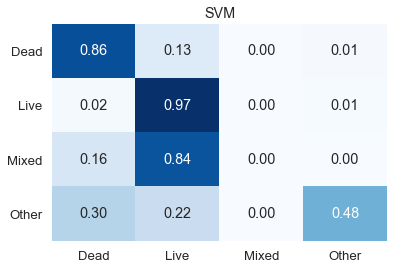

In [26]:
cm = confusion_matrix(Y_test, lin_svm_preds)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("SVM")
plt.yticks(rotation=0)
plt.show()

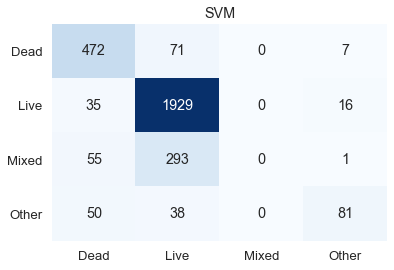

In [27]:
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(reordered_cm, annot=True, cmap="Blues", fmt="0", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("SVM")
plt.yticks(rotation=0)

plt.show()

### SVM without RandomSearchCV

In [28]:
#Create a svm Classifier with linear kernel
modelSVM = svm.SVC(kernel='linear') 

#Train the model using the training sets
modelSVM.fit(X_train, Y_train)

#Predict the response for test dataset
Y_train_Preds_SVM = modelSVM.predict(X_train)
Y_test_Preds_SVM = modelSVM.predict(X_test)


# accuracy
print('Train accuracy', accuracy_score(Y_train,Y_train_Preds_SVM ))
print('Test accuracy', accuracy_score(Y_test, Y_test_Preds_SVM))

Train accuracy 0.8111848030786867
Test accuracy 0.8126640419947506


In [30]:
print(f'OA: {accuracy_score(Y_test, Y_test_Preds_SVM):.2f}, BA: {balanced_accuracy_score(Y_test, Y_test_Preds_SVM):.2f}, Kappa: {cohen_kappa_score(Y_test, Y_test_Preds_SVM):.2f}')
print(classification_report(Y_test, Y_test_Preds_SVM, target_names=classes))

OA: 0.81, BA: 0.57, Kappa: 0.60
              precision    recall  f1-score   support

        dead       0.77      0.86      0.81       550
       mixed       0.00      0.00      0.00       349
        live       0.83      0.97      0.89      1980
       Other       0.77      0.46      0.57       169

    accuracy                           0.81      3048
   macro avg       0.59      0.57      0.57      3048
weighted avg       0.72      0.81      0.76      3048



C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


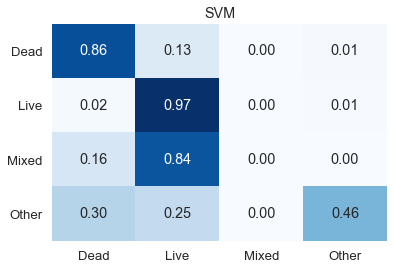

In [31]:
cm = confusion_matrix(Y_test, Y_test_Preds_SVM)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]


sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("SVM")
plt.yticks(rotation=0)
plt.show()

### XGBOOST with RandomSearchCV

In [32]:
#xgb = XGBClassifier(objective="multi:softprob", random_state=42 )

xgb = xgb.XGBClassifier()


xgb_paramgrid = {
    'gamma': [0, 0.1, 0.2],
    'learning_rate': (0.05,0.10,0.15), 
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [2, 4, 6, 8], 
    'max_features': ['auto', 'log2', None],
    'min_samples_split':list(range(2,5)),
    'colsample_bytree': [0.6, 0.4]}



xgb_search = RandomizedSearchCV(xgb, xgb_paramgrid, cv=5, n_iter=5, n_jobs=-1, verbose=2, random_state=seed)

In [33]:
xgb_search.fit(X_train,Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:    8.4s remaining:   21.7s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   13.2s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   16.4s finished
C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "criterion", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:25:46] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                   

In [34]:
best_xgb = xgb_search.best_estimator_
print(best_xgb)

xgb_preds_train = best_xgb.predict(X_train)
xgb_preds = best_xgb.predict(X_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              criterion='friedman_mse', enable_categorical=False, gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              max_features=None, min_child_weight=1, min_samples_split=4,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=16, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact', ...)


In [35]:
print(f'OA: {accuracy_score(Y_test, xgb_preds):.2f}, BA: {balanced_accuracy_score(Y_test, xgb_preds):.2f}, Kappa: {cohen_kappa_score(Y_test, xgb_preds):.2f}')
print(classification_report(Y_test, xgb_preds, target_names=classes))

OA: 0.82, BA: 0.60, Kappa: 0.62
              precision    recall  f1-score   support

        dead       0.79      0.84      0.81       550
       mixed       0.42      0.15      0.22       349
        live       0.85      0.96      0.90      1980
       Other       0.71      0.45      0.55       169

    accuracy                           0.82      3048
   macro avg       0.69      0.60      0.62      3048
weighted avg       0.78      0.82      0.79      3048



In [36]:
print('Train accuracy', accuracy_score(Y_train, xgb_preds_train)*100)
print('Validation accuracy', (xgb_search.best_score_)*100)
print('Test accuracy', accuracy_score(Y_test, xgb_preds)*100)

Test accuracy 91.86931957749938
Validation accuracy 81.0202477251188
Test accuracy 81.56167979002625


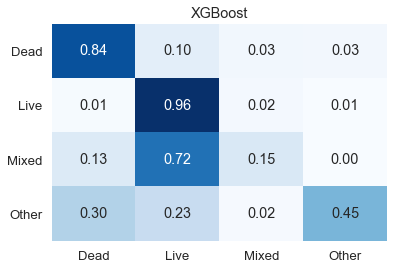

In [37]:
cm = confusion_matrix(Y_test, xgb_preds)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("XGBoost")
plt.yticks(rotation=0)
plt.show()

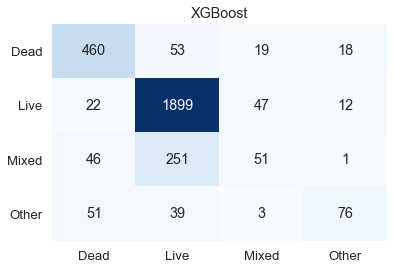

In [38]:
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(reordered_cm, annot=True, cmap="Blues", fmt="0", xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.title("XGBoost")
plt.yticks(rotation=0)

plt.show()

### XGBoost without RandomSearchCV

In [39]:
# Gradient boosted tree
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
import xgboost as xgb

modelXGB = xgb.XGBClassifier(objective="multi:softprob", random_state=42 )

modelXGB.fit(X_train, Y_train)

# mdoel prediction
Y_test_Preds_XGB = modelXGB.predict(X_test)


print(confusion_matrix(Y_test, Y_test_Preds_XGB))
print('Test accuracy', accuracy_score(Y_test, Y_test_Preds_XGB))

[00:25:50] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[ 443   34   51   22]
 [  44   86  217    2]
 [  21   62 1883   14]
 [  48    5   37   79]]
Test accuracy 0.8172572178477691


In [41]:
print(f'OA: {accuracy_score(Y_test, Y_test_Preds_XGB):.2f}, BA: {balanced_accuracy_score(Y_test, Y_test_Preds_XGB):.2f}, Kappa: {cohen_kappa_score(Y_test, Y_test_Preds_XGB):.2f}')
print(classification_report(Y_test, Y_test_Preds_XGB, target_names=classes))

OA: 0.82, BA: 0.62, Kappa: 0.63
              precision    recall  f1-score   support

        dead       0.80      0.81      0.80       550
       mixed       0.46      0.25      0.32       349
        live       0.86      0.95      0.90      1980
       Other       0.68      0.47      0.55       169

    accuracy                           0.82      3048
   macro avg       0.70      0.62      0.64      3048
weighted avg       0.79      0.82      0.80      3048



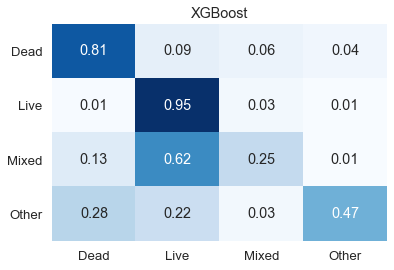

In [42]:
cm = confusion_matrix(Y_test, Y_test_Preds_XGB)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("XGBoost")
plt.yticks(rotation=0)
plt.show()

# ANN Confusion Matrix

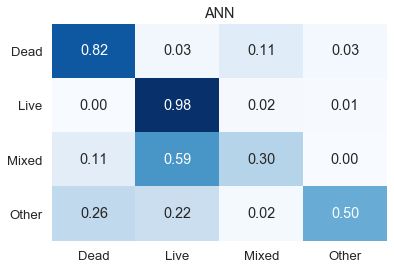

In [43]:
ANN_CM = [[ 453,   19 ,  63 ,  15],
 [   3 ,1931 ,  32 ,  14],
 [  37 , 207,  104 ,   1],
 [  44 ,  38  ,  3 ,  84]]


cm= np.array(ANN_CM)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

#plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("ANN")
plt.yticks(rotation=0)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
plt.show()

In [44]:
import numpy as np

# Define your confusion matrix
CM = np.array([[ 453,   19 ,  63 ,  15],
 [   3 ,1931 ,  32 ,  14],
 [  37 , 207,  104 ,   1],
 [  44 ,  38  ,  3 ,  84]])

# Calculate precision, recall, and F1 score for each class
precision = np.zeros(CM.shape[0])
recall = np.zeros(CM.shape[0])
f1_score = np.zeros(CM.shape[0])

for i in range(CM.shape[0]):
    TP = CM[i, i]
    FP = np.sum(CM[:, i]) - TP
    FN = np.sum(CM[i, :]) - TP
    
    precision[i] = TP / (TP + FP)
    recall[i] = TP / (TP + FN)
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

# Now, precision, recall, and F1 score are calculated for each class
for i in range(CM.shape[0]):
    print(f"Class {i+1}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1 Score={f1_score[i]:.2f}")


Class 1: Precision=0.84, Recall=0.82, F1 Score=0.83
Class 2: Precision=0.88, Recall=0.98, F1 Score=0.93
Class 3: Precision=0.51, Recall=0.30, F1 Score=0.38
Class 4: Precision=0.74, Recall=0.50, F1 Score=0.59


# All CMs for RF, SVM, XGBoost, ANN

In [45]:
rf = confusion_matrix(Y_test, rf_preds)
reordered_rf = rf[np.ix_(class_order, class_order)]
rf_normalized = reordered_rf.astype('float') / reordered_rf.sum(axis=1)[:, np.newaxis]

svm = confusion_matrix(Y_test, lin_svm_preds)
reordered_svm = svm[np.ix_(class_order, class_order)]
svm_normalized = reordered_svm.astype('float') / reordered_svm.sum(axis=1)[:, np.newaxis]

xgb = confusion_matrix(Y_test, xgb_preds)
reordered_xgb = xgb[np.ix_(class_order, class_order)]
xgb_normalized = reordered_xgb.astype('float') / reordered_xgb.sum(axis=1)[:, np.newaxis]

ann = np.array(ANN_CM) 
ann_normalized = ann.astype('float') / ann.sum(axis=1)[:, np.newaxis]

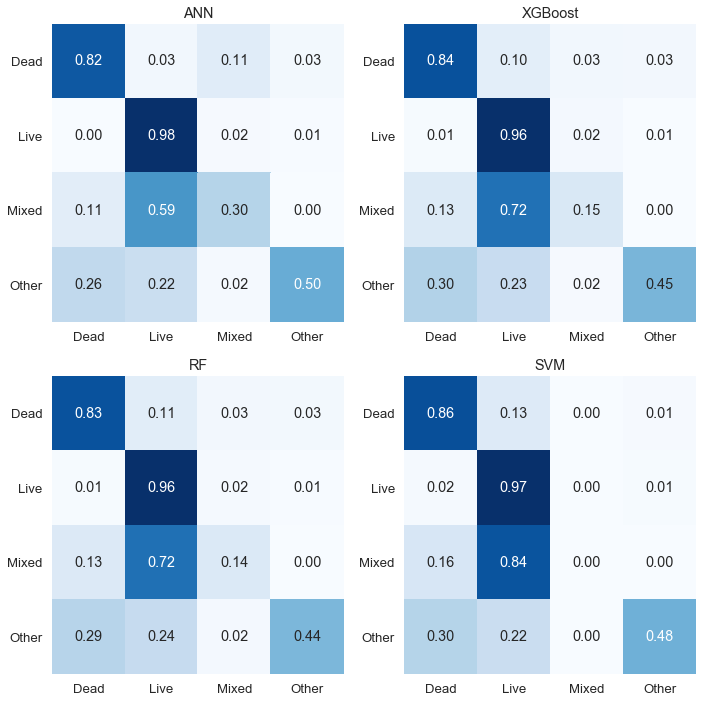

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt


heatmap_data = [ann_normalized, xgb_normalized, rf_normalized, svm_normalized]

# Create a figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# Plot heatmaps on each subplot
for data, ax in zip(heatmap_data, [ax1, ax2, ax3, ax4]):
    sns.heatmap(data, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False, ax =ax)
    ax.yaxis.set_tick_params(rotation=0)

# Set titles for each subplot

ax1.set_title("ANN")
ax2.set_title("XGBoost")
ax3.set_title("RF")
ax4.set_title("SVM")

plt.tight_layout()
plt.savefig('M:/review_23/figures_tables_review/RGB_CM_Normalized.jpeg', dpi=300, bbox_inches='tight')
plt.show()


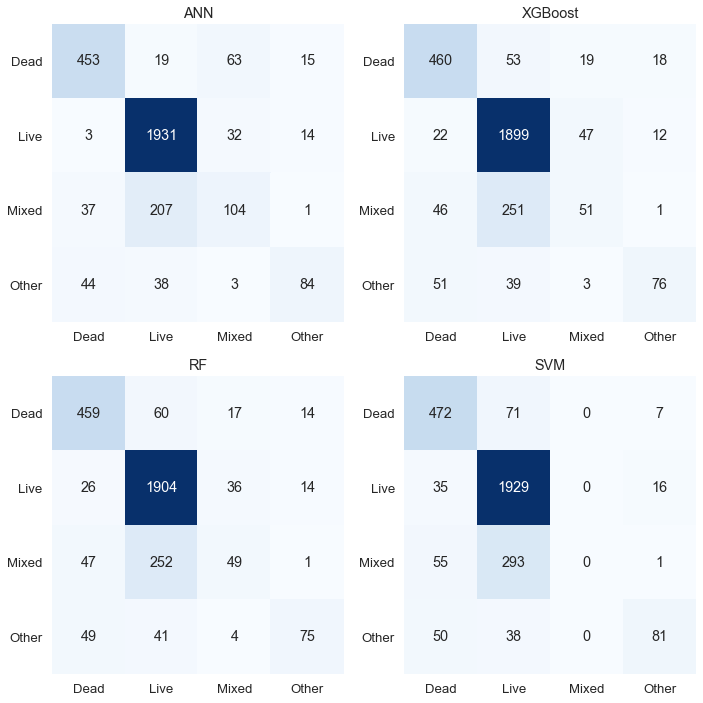

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt


heatmap_data = [ann,reordered_xgb, reordered_rf, reordered_svm ]

# Create a figure and subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# Plot heatmaps on each subplot
for data, ax in zip(heatmap_data, [ax1, ax2, ax3, ax4]):
    #sns.heatmap(data, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, ax=ax, cbar=False)
    sns.heatmap(data, annot=True, cmap="Blues", fmt="0", xticklabels=class_names, yticklabels=class_names, cbar= False, ax =ax)
    ax.yaxis.set_tick_params(rotation=0)

# Set titles for each subplot

ax1.set_title("ANN")
ax2.set_title("XGBoost")
ax3.set_title("RF")
ax4.set_title("SVM")

plt.tight_layout()
plt.savefig('M:/review_23/figures_tables_review/RGB_CM_Not_Normalized.jpeg', dpi=300, bbox_inches='tight')
plt.show()


# LOGISTIC REGRESSION

In [48]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import numpy as np



# Define hyperparameter grid
param_dist = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    'multi_class': ['ovr', 'multinomial']
}

# Create a logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Create RandomizedSearchCV object
random_log = RandomizedSearchCV(
    logreg, 
    param_distributions=param_dist, 
    n_iter=5, 
    cv=5, 
    verbose=2, 
    n_jobs=-1
)

# Perform the random search
random_log.fit(X_train, Y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", random_log.best_params_)

best_logReg = random_log.best_estimator_
best_logReg

logReg_preds_train = best_logReg.predict(X_train)
logReg_preds = best_logReg.predict(X_test)

print(f'OA: {accuracy_score(Y_test, logReg_preds):.2f}, BA: {balanced_accuracy_score(Y_test, logReg_preds):.2f}, Kappa: {cohen_kappa_score(Y_test, logReg_preds):.2f}')
print(classification_report(Y_test, logReg_preds, target_names=classes))

print('Train accuracy', accuracy_score(Y_train, logReg_preds_train)*100)
print('Validation accuracy', (random_log.best_score_)*100)
print('Test accuracy', accuracy_score(Y_test, logReg_preds)*100)



Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   26.9s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   30.4s finished
C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best hyperparameters: {'solver': 'saga', 'penalty': 'l1', 'multi_class': 'ovr', 'C': 3792.690190732246}
OA: 0.81, BA: 0.57, Kappa: 0.59
              precision    recall  f1-score   support

        dead       0.77      0.85      0.80       550
       mixed       0.37      0.02      0.04       349
        live       0.83      0.97      0.89      1980
       Other       0.74      0.46      0.57       169

    accuracy                           0.81      3048
   macro avg       0.68      0.57      0.58      3048
weighted avg       0.76      0.81      0.76      3048

Test accuracy 80.79914844837468
Validation accuracy 79.93124147851942
Test accuracy 81.00393700787401


C:\Users\upanpra\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


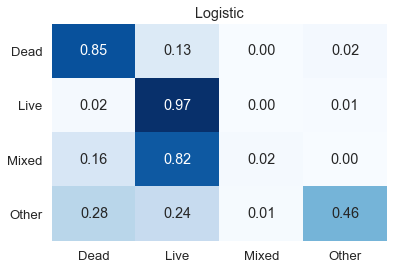

In [49]:
cm = confusion_matrix(Y_test, logReg_preds)

reordered_cm = cm[np.ix_(class_order, class_order)]

cm_normalized = reordered_cm.astype('float') / reordered_cm.sum(axis=1)[:, np.newaxis]

sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm_normalized, annot=True, cmap="Blues", fmt=".2f", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("Logistic")
plt.yticks(rotation=0)
plt.show()

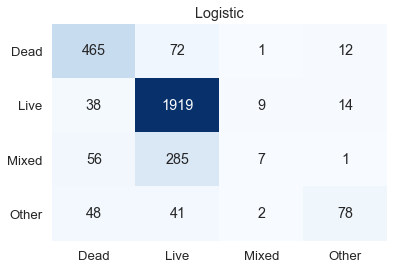

In [50]:
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(reordered_cm, annot=True, cmap="Blues", fmt="0", xticklabels=class_names, yticklabels=class_names, cbar= False)
plt.title("Logistic")
plt.yticks(rotation=0)
plt.show()